In [1]:
import copy
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from numba import float32, float64, jit, NumbaPerformanceWarning
import warnings
import os
import yaml

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

from utils import simulate_onestep_campi_example_1

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

from dataset_simple_example_1 import SimpleExample1Dataset

In [2]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# from transformer_onestep import GPTConfig, GPT
from transformer_sim import Config, TSTransformer
import tqdm
import argparse
import metrics

In [3]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [4]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [7]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 50 # 256

# Compute settings
cuda_device = "cuda:1"
no_cuda = True
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [8]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_sim_simple_example_1_fixed.pt", map_location=device)

In [11]:
seq_len_ctx = exp_data["cfg"].seq_len_ctx
seq_len_new = exp_data["cfg"].seq_len_new
nx = exp_data["cfg"].nx

In [12]:
model_args = exp_data["model_args"]
conf = Config(**model_args)
model = TSTransformer(conf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict);

In [15]:
import pickle as pkl

with open('../../data/control/test_set_simple_example_1_5%_perturbation.pkl', 'rb') as f:
    test_set = pkl.load(f)

data_test = test_set['data_test']

In [16]:
from control.matlab import *
generate_from_model = False

if generate_from_model:
    dtype="float32"
    n_context = 500
    
    ts = 1e-2; fs = 1/ts
    s = tf('s')
    z = tf([1, 0], [1], dt=ts)
    
    # VRFT
    s = tf('s')
    tau = 1 # s
    M = 1/(1 + (tau/(2*np.pi))*s)
    M = c2d(M, ts, 'matched')
    M_proper = z * M
    
    # Specifics for OL experiment
    T = 20
    t_exp = np.arange(0, T, ts)
    t = np.arange(0, n_context*ts, ts)
    
    # To store results
    U = np.zeros((len(data_test), n_context))
    Y = np.zeros((len(data_test), n_context))
    Y_d = np.zeros((len(data_test), n_context))
    E = np.zeros((len(data_test), n_context))
    R = np.zeros((len(data_test), n_context))
    
    for i, data in enumerate(data_test):
        
        num = [data['num_1']]
        den = [data['den_1'], data['den_2'], data['den_3']]
    
        G_continuous = tf(num,den)
        G = c2d(G_continuous, ts, 'matched')
        
        u = np.random.normal(0, 1000, t_exp.shape)
        y = lsim(G, u, t_exp)[0]
    
        u_L = lsim(M, u, t_exp)[0]
        y_L = lsim(M, y, t_exp)[0]
        r_v = lsim(M_proper ** (-1), y_L, t_exp)[0]
        e_v = (r_v - y_L)
    
        u_L = u_L
    
        # normalize
        e_v = e_v / 4.8320#2.22  # mean 0, std 10
        u_L = u_L / 175.1#62.3#118.5  # mean 0, std 17
    
        
        # lunghezza contesto 5
        start_idx = np.random.randint(500, len(e_v)-n_context)
        # start_idx = 0
        e_v = e_v[start_idx:start_idx + n_context] # this is e(t), ... e(t+N)
        u_L = np.insert(u_L, 0, 1e-6)
        u_L = u_L[start_idx:start_idx + n_context] # this is u(t-1), ... u(t+N-1)
        y_L = y_L[start_idx:start_idx + n_context] # this is u(t-1), ... u(t+N-1)
        r_v = r_v[start_idx:start_idx + n_context]
        
        E[i,:] = e_v
        U[i,:] = u_L
        Y[i,:] = y_L
        R[i,:] = r_v
        Y_d[i,:] = lsim(M, r_v, t)[0]
        
    t_CL = t
    r_batch = R
    
else:
    ts = 1e-2
    T = 20#5#seq_len*ts
    t_CL = np.arange(0, T, ts)
    r_batch = np.zeros((batch_size, len(t_CL)))
    r = np.zeros(t_CL.shape)
    r[t_CL < 20] = 10
    r[(t_CL >= 2.5) & (t_CL < 5)] = -10
    r[(t_CL >= 5.0) & (t_CL < 7.5)] = 0
    r[(t_CL >= 7.5) & (t_CL < 10)] = 5
    r[(t_CL >= 10.) & (t_CL < 12.5)] = -5
    r[(t_CL >= 12.5) & (t_CL < 15.)] = 20
    r[(t_CL >= 15.0) & (t_CL < 17.5)] = 0
    r[(t_CL >= 17.5) & (t_CL < 20.0)] = -20
    
    for i in range(r_batch.shape[0]):
        # get virtual error
        r_batch[i,:] = r

In [17]:
# from control.matlab import *
# # Generate the reference
# generate_from_model = False
# ts = 1e-2
# T = 20#5#seq_len*ts
# t_CL = np.arange(0, T, ts)
# r_batch = np.zeros((batch_size, len(t_CL)))
# 
# if generate_from_model:
#     test_ds = SimpleExample1Dataset(seq_len=len(t_CL), normalize=True, return_y=True)
#     test_dl = DataLoader(test_ds, batch_size=batch_size)
#     batch_u, batch_e, batch_y, batch_r = next(iter(test_dl))
#     for i in range(r_batch.shape[0]):
#         # get virtual error
#         r_batch[i,:] = batch_r[i,:,0]
# else:
#     r = np.zeros(t_CL.shape)
#     r[t_CL < 20] = 10
#     r[(t_CL >= 2.5) & (t_CL < 5)] = -10
#     r[(t_CL >= 5.0) & (t_CL < 7.5)] = 0
#     r[(t_CL >= 7.5) & (t_CL < 10)] = 5
#     r[(t_CL >= 10.) & (t_CL < 12.5)] = -5
#     r[(t_CL >= 12.5) & (t_CL < 15.)] = 20
#     r[(t_CL >= 15.0) & (t_CL < 17.5)] = 0
#     r[(t_CL >= 17.5) & (t_CL < 20.0)] = -20
#     for i in range(r_batch.shape[0]):
#         # get virtual error
#         r_batch[i,:] = r

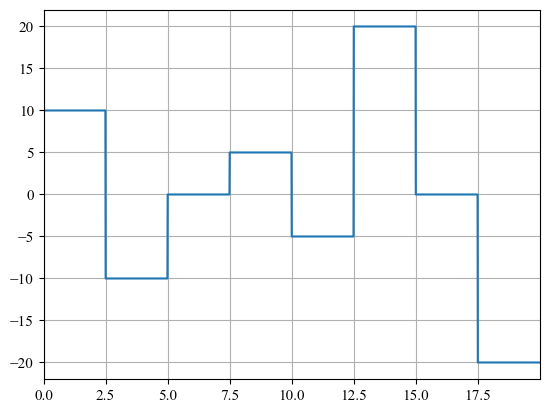

In [18]:
plt.plot(t_CL, r_batch[0,:])

In [23]:
with open('normalization_params.yaml', 'r') as file:
    config = yaml.safe_load(file)
    
prefilter_key = 'prefilter'
signal_key = 'white noise'
signal_config = config.get(signal_key, {}).get(prefilter_key, {})
e_std = signal_config.get('e_std')
u_std = signal_config.get('u_std')
y_std = signal_config.get('y_std')

In [37]:
import copy
n_testing = 0
H = 400

y_log = np.empty((len(data_test),len(t_CL)))
e_log = np.empty((len(data_test),len(t_CL)))
u_log = np.empty((len(data_test),len(t_CL)))

Ts = 1e-2; Fs = 1 / Ts
s = tf('s')

# problem data

# (e_t, u_{t-1}) -> Transformer -> u_t

# x(0), u(-1) = 0, y(0), e(0) = r(0) - y(0)

with torch.no_grad():
    for n_testing in range(1):#len(data_test)):
        
        # print(n_testing)
        
        # e = torch.Tensor([[[]]])
        # e_int = torch.Tensor([[[]]])
        # u = torch.Tensor([[[]]])
        e = np.array([])
        # e_int = np.array([])
        u = np.array([])
        y = np.array([])
        
        # This is like t=0, for our model we need u(-1).
        x_i = np.array([[0, 0]]) # x(0)
        y_i = x_i[:,1]    # y(0)
        u_prev = 0 # u(-1)

        data = data_test[n_testing]
        # system
        num = [data['num_1']]
        den = [data['den_1'], data['den_2'], data['den_3']]
        P = tf(num, den)
        
        for i in range(0,len(t_CL)):#batch_u.shape[0]): # for each system
            
            # print(i)
            # if i == 6:
            #     print('e:', e[0, 0, :5])
            #     print('u:', u[0, 0, :5])
            #     print('u_hat:', pred[0, :5, 0])
            #     print('y:', y_log[0, :5])
            #     print('x:', x_i)

            e_i = r_batch[n_testing,i] - y_i # e(t)
            
            y_log[n_testing,i] = y_i
            e_log[n_testing,i] = e_i
            
            # if i == 0:
            #     e_int_i = e_i
            # else:
            #     e_int_i = np.cumsum(e_log[n_testing,:].flatten())[-1] + e_i
                
            e = np.hstack((e, e_i / e_std))#4.8320))
            # e_int = np.hstack((e_int, e_int_i / 70))
            u = np.hstack((u, u_prev / u_std))#175.1))
            y = np.hstack((y, y_i / y_std))
            
            # Convert to torch.Tensor just before feeding to model
            e_tensor = torch.tensor(e, dtype=torch.float32).reshape(1, -1, 1)
            u_tensor = torch.tensor(u, dtype=torch.float32).reshape(1, -1, 1)
            y_tensor = torch.tensor(y, dtype=torch.float32).reshape(1, -1, 1)
    

            # # print(e_i.shape)
            # e = torch.cat((e, copy.deepcopy(e_i)), 2)    #  e(0), ..., e(t)
            # e_int = torch.cat((e_int, copy.deepcopy(e_int_i) / 70), 2)    #  e(0), ..., e(t)
            # u = torch.cat((u, copy.deepcopy(u_prev) / 118.5), 2) # u(-1), ..., u(t-1)
            # 
            
            # Controller u(t) = C(e(t),u(t-1))
            # print(e_tensor[:, -1:, :])
            
            if i < H:
                pred = model(y_tensor, u_tensor, e_tensor[:, -1:, :])
            else:
                pred = model(y_tensor[:, -H:, :], u_tensor[:, -H:, :], e_tensor[:, -1:, :])
            
            # if i == 5:
            #     break
    
            u_i = pred[:,-1,:].item() * u_std # u(t)
            u_log[n_testing,i] = u_i
    
            # simulation
            y_i, t_out, x_i = lsim(P, u_i, np.array([0, Ts]), x_i[-1], return_x=True)
            y_i = y_i[-1]  # y(t) <- y(t+1)
            u_prev = u_i # u(t-1)

/tmp/ipykernel_1382392/3376126252.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_log[n_testing,i] = y_i
/tmp/ipykernel_1382392/3376126252.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e_log[n_testing,i] = e_i


In [38]:
# print('e:', e_tensor[0, :5, 0])
# print('u:', u_tensor[0, :5, 0])
# print('u:', u_log[0, :5]/175.1)
# # print('u_hat:', batch_u_pred[0, :5, 0])
# print('y:', y_log[0, :5])
# print('r:', r_batch[0, :5])

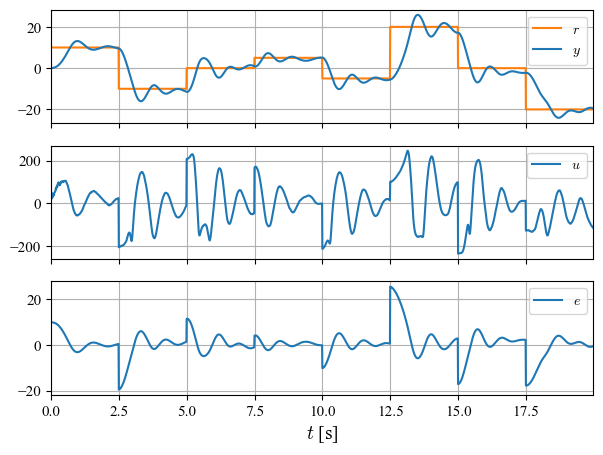

In [39]:
fig = plt.figure(figsize=(7, 5))
ax1 = plt.subplot(311)
#plt.plot(t_CL, r)
plt.plot(t_CL, r_batch[n_testing,:], label="$r$", c='tab:orange')
plt.plot(t_CL, y_log[0,:].T, label="$y$", c='tab:blue', alpha=1)
plt.legend(['$r$','$y$'])
# plt.xlim([0, 0.43])
# plt.ylim([0, 10])
plt.tick_params('x', labelbottom=False)

ax2 = plt.subplot(312, sharex=ax1)
plt.plot(t_CL, u_log[0,:].T, c='tab:blue', alpha=1)
plt.legend(['$u$'])
# plt.ylim([-500, 2000])
plt.tick_params('x', labelbottom=False)

ax3 = plt.subplot(313, sharex=ax1)
plt.plot(t_CL, e_log[0,:].T, c='tab:blue', alpha=1)
plt.xlabel('$t$ [s]')
# plt.ylim([0, 4])
plt.legend(['$e$'])

# plt.savefig('transformer_controller.pdf')

plt.show()

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

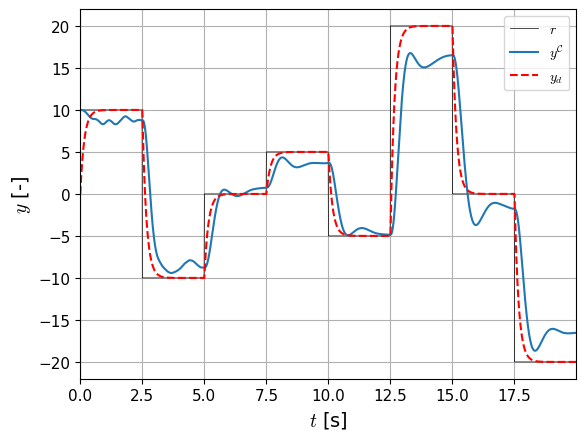

In [56]:
s = tf('s')
tau = 1 # s
M = 1/(1 + (tau/(2*np.pi))*s)
M = c2d(M, ts, 'matched')

y_d = lsim(M, r, t_CL, return_x=False)[0]

plt.plot(t_CL, r_batch[n_testing,:], color='k', linewidth=0.5, label='$r$')
plt.plot(t_CL, y_log[0,:].T, label=r'$y^{\mathcal{C}}$')
plt.plot(t_CL, y_d, color='r', linestyle='--', label='$y_d$')
plt.xlabel("$t$ [s]")
plt.ylabel("$y$ [-]")
plt.legend()
plt.margins(x=0)
plt.show()